In [1]:
import numpy as np, matplotlib.pyplot as plt, cv2, tqdm
from importlib import reload
%matplotlib inline

In [2]:
from utils import saveVideo, show, drawShape

In [3]:
import laneFindingPipeline

In [4]:
# Load video
fpath = 'project_video.mp4'
import skvideo.io
reader = skvideo.io.FFmpegReader(fpath)
frames = []
for (i, f) in enumerate(tqdm.tqdm_notebook(
    reader.nextFrame(), 
    total=reader.inputframenum,
)):
    frames.append(f)

A Jupyter Widget

In [5]:
reload(laneFindingPipeline)
laneFinder = laneFindingPipeline.LaneFinder()

bases = [[], []]
yall = [[], []]
xall = [[], []]
for frame in tqdm.tqdm_notebook(frames[:64], unit='frame'):
    laneFinder(frame)
    left, right = laneFinder.markingFinder.markings
    
    # Extract the lane bases x(y=720).
    bases[0].append(left(720))
    bases[1].append(right(720))
    
    yall[0].append(np.copy(left.y))
    yall[1].append(np.copy(right.y))
    
    xall[0].append(np.copy(left.x))
    xall[1].append(np.copy(right.x))
    
    

A Jupyter Widget

A Jupyter Widget

Some lane markings failed inspection!



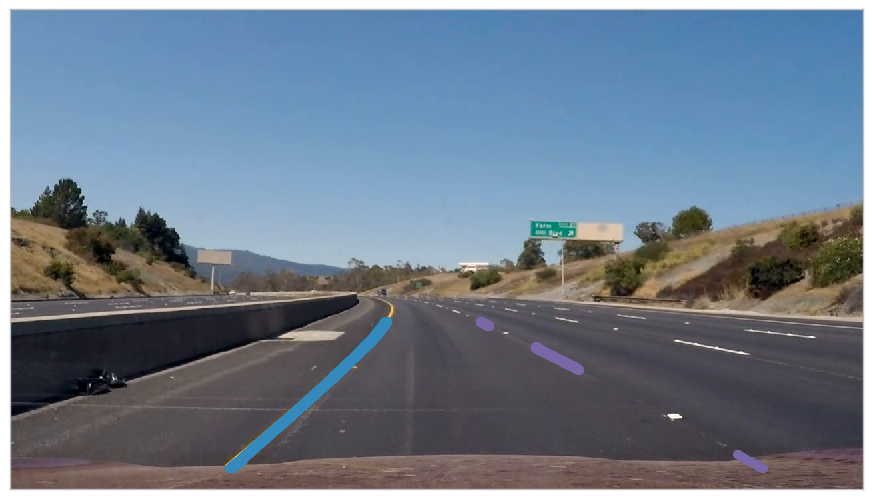

In [6]:
iframe = 10
fig, ax = show(frames[iframe])
for i in range(2):
    y = yall[i][iframe]
    x = xall[i][iframe]
    x, y = laneFinder.perspective.callOnPoints(x, y, inv=True)
    ax.scatter(x, y)

In [7]:
hist2mode = lambda binCounts, binEdges, _: binEdges[np.argmax(binCounts):][:2].mean()

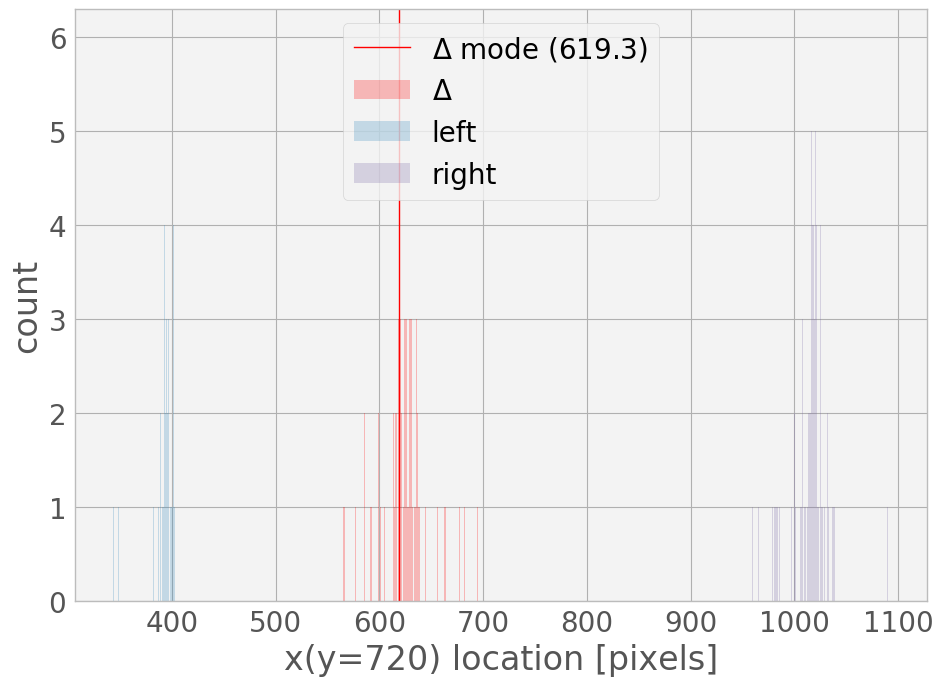

In [8]:
fig, ax = plt.subplots()
nbins = 128

alpha = .25
y = 720
    
dcolor = 'red'
mode = hist2mode(*ax.hist(
    np.array(bases[1]) - np.array(bases[0]), 
    bins=nbins, label='$\Delta$', alpha=alpha, color=dcolor
))
ax.axvline(mode, label='$\Delta$ mode (%.4g)' % mode, color=dcolor)

for baselist, label in zip(bases, ['left', 'right']):
    ax.hist(baselist, bins=nbins, label=label, alpha=alpha)

ax.legend()
ax.set_xlabel('x(y=%d) location [pixels]' % y)
ax.set_ylabel('count');
fig.savefig('doc/laneBaseDifferenceHistogram.png')

In [9]:
mode

619.25482408558491

In [10]:
xm_per_pix = 3.7 / mode

In [11]:
laneLengths = [[], []]    
for i in tqdm.tqdm_notebook(range(len(yall[0]))):
    # Extract the lane lengths (spans).
    for ll, laney in zip(laneLengths, [yall[0][i], yall[1][i]]):
#         ypix = set(laney)
        ll.append(max(laney) - min(laney))

A Jupyter Widget

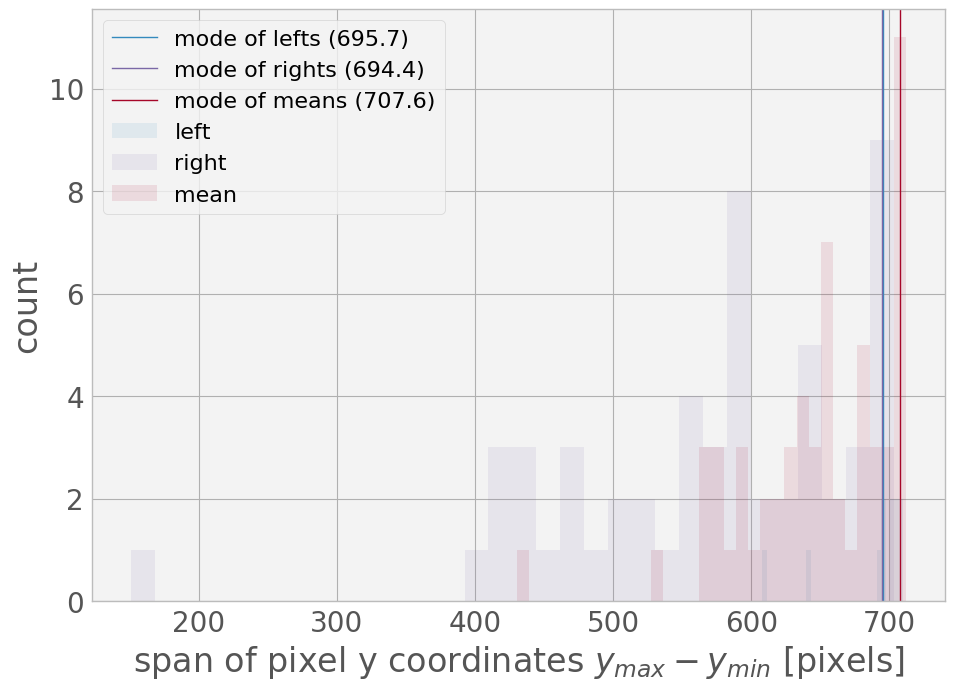

In [12]:
fig, ax = plt.subplots()
nbins = 32
alpha = .1
    
meanLengths = sum([np.array(ll) for ll in laneLengths]) / len(laneLengths)
for ll, label in zip(
    [laneLengths[0], laneLengths[1], meanLengths], 
    ['left', 'right', 'mean']
):
    ll = np.array(ll)
    ll = ll[ll < 715]
    a, b, c = ax.hist(ll, bins=nbins, label=label, alpha=alpha)
    color = c[0].get_facecolor()[:-1]
    mode = hist2mode(a,b,c)
    ax.axvline(mode, color=color, label='mode of %ss (%.4g)' % (label, mode))
    
ax.legend(fontsize=16)
ax.set_xlabel('span of pixel y coordinates $y_{max}-y_{min}$ [pixels]')
ax.set_ylabel('count');
fig.savefig('doc/laneHeightHistogram.png')

In [13]:
mode

707.6015625

In [14]:
ym_per_pix = 30 / mode

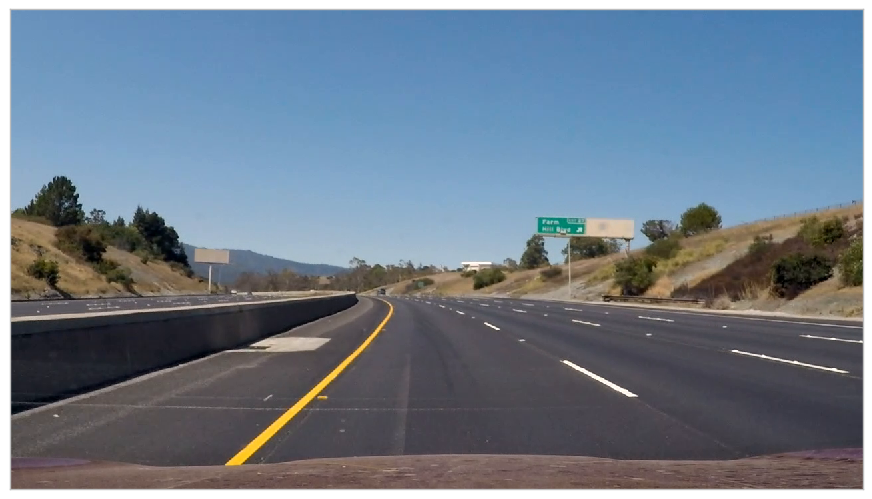

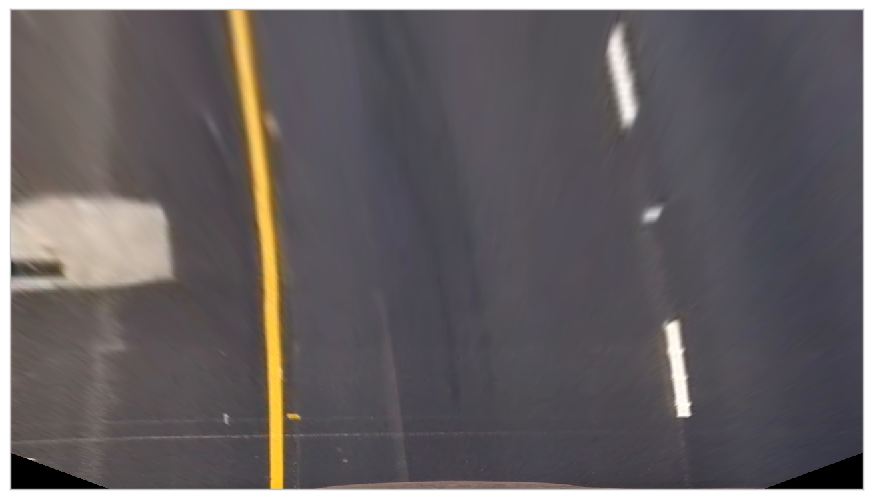

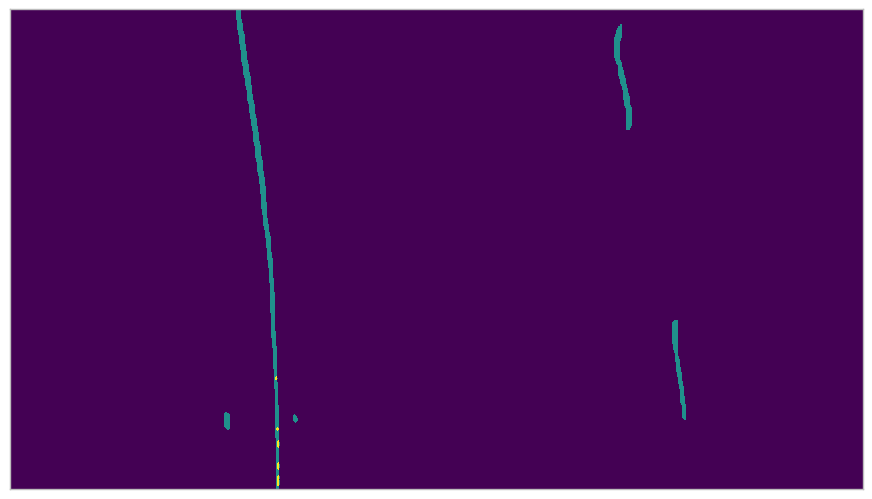

In [15]:
frame = frames[13]
preprocessed = laneFinder.preprocess(frame)
warped = laneFinder.perspective(laneFinder.undistort(frame))

show(frame);
show(warped);
show(preprocessed);

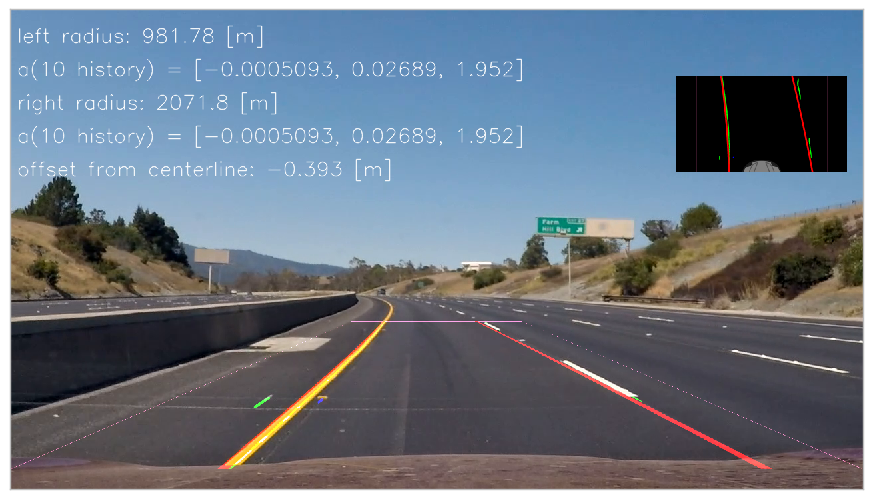

In [16]:
show(laneFinder.draw(frame, showCentroids=False, showCurves=True, showLane=False));

In [17]:
left, right = laneFinder(frame)

In [18]:
left.radius, right.radius

(944.04096725274212, 2661.2450386136325)

In [19]:
ybasePixels = 720-laneFinder.perspective.hoodPixels
ybase = left.ym_per_pix*(ybasePixels)

In [20]:
right(ybase, worldCoordinates=True) - left(ybase, worldCoordinates=True)

3.6237926464394592

In [21]:
(right(ybasePixels) - left(ybasePixels))*left.xm_per_pix

3.623792646439469

In [22]:
centerline = np.mean([left(720), right(720)])
metersRightOfCenter = (1280/2 - centerline) * left.xm_per_pix

How many feet right of center are we?

In [23]:
metersRightOfCenter * 3.2808

-1.3153039881838675

In [24]:
reload(laneFindingPipeline)
laneFinder = laneFindingPipeline.LaneFinder()

# prime the lanefinder
iframe = 407
for frame in tqdm.tqdm_notebook(frames[iframe-20:iframe+1], unit='frame'):
    laneFinder(frame)
    left, right = laneFinder.markingFinder.markings

A Jupyter Widget

A Jupyter Widget

[California lane marking spacing standards](http://www.dot.ca.gov/trafficops/camutcd/camutcd2014rev2.html) say that these white broken highway markings should be 12 feet long, and there should be a small dot centered in the 36-foot gap between markings. Lanes are generally [12 feet wide](http://www.dot.ca.gov/hq/paffairs/faq/faq92.htm).

In [25]:
(12+18+18+12) / 3.2808

18.2882223847842

In [26]:
12 / 3.2808

3.6576444769568397

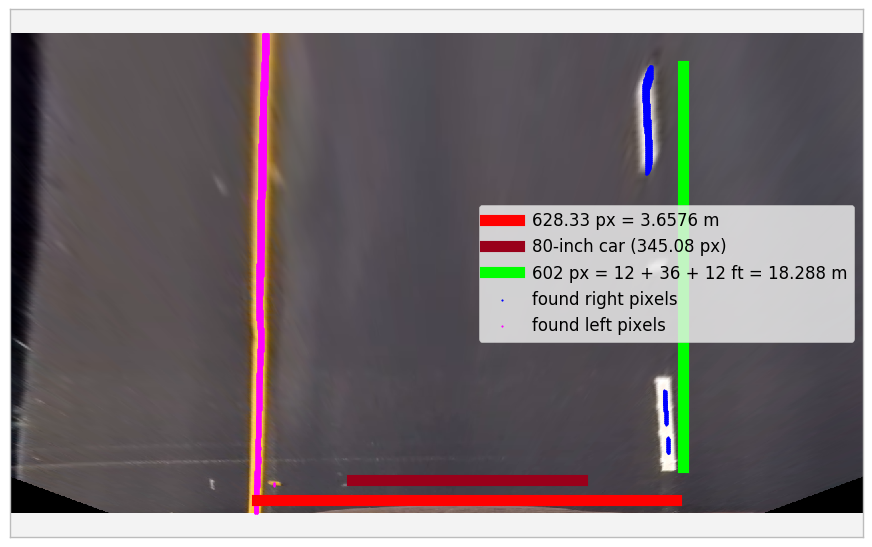

In [28]:
preprocessed = laneFinder.preprocess(frame)
warped = laneFinder.perspective(laneFinder.undistort(frame))

fig, ax = plt.subplots()
show(warped, ax=ax);

linewidth = 8

y = 700
X = [left(y), right(y)]
ax.plot(
    X, [y,y], color='red', linewidth=linewidth,
    label='%.5g px = 3.6576 m' % (X[1] - X[0],)
)

carWidth = 80 / 12 / 3.2808
laneFraction = carWidth / 3.7
carPixelsWide = laneFraction * (max(X) - min(X))
lackHalf = carPixelsWide * (1 - laneFraction) / 2 / laneFraction

ax.plot(
    [X[0] + lackHalf, X[1] - lackHalf], 
    [y - 30, y - 30],
    color=(.6, 0, .1),
    linewidth=linewidth,
    label='80-inch car (%.5g px)' % carPixelsWide,
)

x = right(y) + 10
Y = min(right.y), max(right.y) + 20
ax.plot(
    [x,x], Y, color=(0,1,0), linewidth=linewidth,
    label='%.5g px = 12 + 36 + 12 ft = 18.288 m' % (Y[1] - Y[0],)
)

ax.scatter(right.x, right.y, color='blue', alpha=1, label='found right pixels', s=1)
ax.scatter(left.x, left.y, color='magenta', alpha=1, label='found left pixels', s=1)

ax.legend(fontsize=12);
fig.savefig('doc/metersPerPixel.png')